### IN THIS NOTEBOOK I WILL SHOW YOU HOW TO MAKE PREDICTION BASED ON A SINGLE IMAGE

**IMPORT MODULES**

In [1]:
from torchvision import transforms
from load_dataset.artgraph import ArtGraph
import torch_geometric.transforms as T
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import copy
import torch
from torch_geometric.nn import HeteroConv, GATConv
from torch.nn import Linear
import torch.nn.functional as F
from torch import nn
import os
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm
from torch.utils.data import DataLoader
from model import ModelClassification

import random
from PIL import Image
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

**SET HERE YOUR SEED AND THE DEVICE**

In [2]:
from torch_geometric.seed import seed_everything
seed_everything(44)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**LOADING THE FEATURE EXTRACTOR**

In [3]:
feature_extractor = torch.load('vit_fine_tune_style.pt')
feature_extractor.to(device)
feature_extractor.reset_classifier(num_classes = 0)
feature_extractor

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
      (ls2): Identity()
     

**REPLACE HERE YOUR IMAGE** (here I make a random choice)

In [4]:
image_path = fr"images-resized/{random.choice(os.listdir('images-resized'))}"
image_path

'images-resized/jan-matejko_sigismund-augustus.jpg'

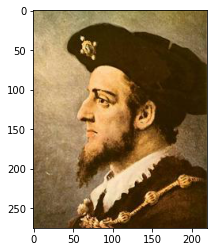

In [5]:
plt.imshow(Image.open(image_path))

In [6]:
def get_image(img_path, transform):
    image = Image.open(img_path)
    if(image.mode != 'RGB'):
        image = image.convert('RGB')
    tensor_image = transform(image)
    return tensor_image

In [7]:
data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [8]:
#getting the image as a tensor
tensor_image = get_image(image_path, data_transforms)

**EXTRACTING VISUAL FEATURES USING THE VISUAL TRANSFORMER**

In [9]:
visual_features = feature_extractor(tensor_image.reshape((1, *tuple(tensor_image.shape), )).to(device))

Since the model requires visual feature vector 128 dimensional, we have used a PCA linear transformation. The instance used has been tuned for the entire dataset.

In [10]:
with open('pca.pk','rb') as pickle_file:
    pca = pickle.load(pickle_file)

In [11]:
visual_features = pca.transform(visual_features.cpu().numpy())
visual_features = torch.from_numpy(visual_features).to(device)

**LOADING THE MODEL THAT IS ABLE TO PREDICT GENRE**

In [12]:
model = torch.load('play_model.pt')
model.to(device)

ModelClassification(
  (encoder): MultiGNNEncoder(
    (activation): Tanh()
    (encoders): ModuleDict(
      (0): HeteroConv(num_relations=1)
    )
  )
  (decoder): Head(
    (head): Sequential(
      (0): Linear(in_features=2432, out_features=1216, bias=True)
      (1): LeakyReLU(negative_slope=0.1, inplace=True)
      (2): Dropout(p=0.25, inplace=False)
      (3): Linear(in_features=1216, out_features=608, bias=True)
      (4): LeakyReLU(negative_slope=0.1, inplace=True)
      (5): Dropout(p=0.25, inplace=False)
      (6): Linear(in_features=608, out_features=304, bias=True)
      (7): LeakyReLU(negative_slope=0.1, inplace=True)
      (8): Dropout(p=0.25, inplace=False)
      (9): Linear(in_features=304, out_features=152, bias=True)
      (10): LeakyReLU(negative_slope=0.1, inplace=True)
      (11): Dropout(p=0.25, inplace=False)
      (12): Linear(in_features=152, out_features=18, bias=True)
    )
  )
)

**LOADING THE GRAPH (REMEMBER THAT THE GRAPH BECOMES AN INPUT IN THIS TYPE OF MODEL)**

In [13]:
graph = torch.load('dataset_full_conf/test_data_genre_vit_fine-tuning.pt')
graph.to(device)

HeteroData(
  artwork={ x=[116475, 128] },
  artist={ x=[2501, 1] },
  gallery={ x=[1099, 1] },
  city={ x=[596, 1] },
  country={ x=[58, 1] },
  style={ x=[32, 1] },
  period={ x=[186, 1] },
  genre={ x=[18, 1] },
  serie={ x=[823, 1] },
  tag={ x=[5424, 1] },
  media={ x=[167, 1] },
  subject={ x=[6985, 1] },
  training_node={ x=[268, 1] },
  field={ x=[54, 1] },
  movement={ x=[243, 1] },
  people={ x=[109, 1] },
  emotion={ x=[9, 1] },
  (artist, belongstofield, field)={ edge_index=[2, 987] },
  (artist, belongstomovement, movement)={ edge_index=[2, 1056] },
  (artist, haspatron, people)={ edge_index=[2, 124] },
  (artist, hassubject, subject)={ edge_index=[2, 21054] },
  (artist, relatedtoschool, training_node)={ edge_index=[2, 498] },
  (artist, trainedby, artist)={ edge_index=[2, 94] },
  (artwork, about, tag)={ edge_index=[2, 241203] },
  (artwork, createdby, artist)={ edge_index=[2, 81532] },
  (artwork, elicit, emotion)={ edge_index=[2, 45649] },
  (artwork, hasgenre, genre)=

In [14]:
predicted_vector = model(graph.x_dict, graph.edge_index_dict, visual_features)

In [15]:
softmax = nn.Softmax(dim = 1)
predicted_vector = softmax(predicted_vector)
predicted_vector

tensor([[1.4176e-05, 4.1672e-06, 2.2152e-06, 1.0466e-01, 1.4381e-04, 7.2605e-05,
         5.2601e-07, 6.6785e-05, 1.8536e-05, 8.9356e-01, 8.1027e-07, 8.0403e-06,
         8.3655e-04, 1.3583e-04, 2.3925e-04, 1.2147e-05, 2.1033e-04, 1.6594e-05]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [16]:
predicted_genre = torch.max(predicted_vector, dim = 1)[1].item()
predicted_genre

9

**SHOWING WHAT GENRE HAS BEEN PREDICTED**

In [17]:
genre2name = pd.read_csv(r'artgraph2bestemotions/mapping/genre_entidx2name.csv', header = None, names = ['idx', 'name'])
genre2name

,idx,name
0,0,nude painting (nu)
1,1,marina
2,2,animal painting
3,3,self-portrait
4,4,genre painting
5,5,symbolic painting
6,6,abstract
7,7,figurative
8,8,landscape
9,9,portrait


In [19]:
f'The precited genre is {genre2name.loc[predicted_genre]["name"].upper()}'

'The precited genre is PORTRAIT'